Nozomu Nakanishi - 2020264 - Msc DA

This notebook presents the technical part of the research which aims develop a neural network for sentiment analysis. The chosen networks <b>is/are, LSTM and (if you have time to develop a different one.</b>
The chronological order will follow: 
1. Introduction;
2. Data preparation and EDA; 
3. Text pre-processing;
4. Embedding and Padding; 
5. LSTM; 
. Conclusion 

## 1. Introduction 

The experiment will be carried out by importing the chosen dataset from Kaggle, the data is licensed under the Creative Commons (CC0 1.0 DEED), allowing the use of the data. 

The link for the dataset is available at kaggle: https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews

The objective of the notebook is to develop a neural network using PySpark (chosen tool for the project) and the chosen dataset to achieve the goal is the recipe reviews from food.com, which is  composed by 8 features and more tham a million rows.
- There are two datasets in the zip file, however it does not says that the recipe ID in one will match the recipe ID in the other, therefore using only the reviews dataset.
- Also, two types of format is available, parquet and csv files. And the choice for the first one is that the parquet file already has a columnar type, which when taking into consideration the tools that are being used such as pyspark it will present a better speed perfomance when performing tasks. In addition to the reduction for its size in megabytes (csv - 496.1 and 173.8). 
- The dataset review, which is going to be manipulated, is about the written reviews along with score rating given. They are the most important features in the dataset to achieve the objective. 

<b>The technical part of the task will be carried out by performing sentiment analysis using Long Short Term Memory (LSTM).....</b>

In [1]:
# The command below is to check where the PySpark is running, 
# in this case (returned:local[*]) data is being processed on my local (personal) machine.

sc.master

'local[*]'

- The libraries to perform the required stages are going to be imported in the next cell.

In [2]:
from pyspark.sql.functions import count # Funcion to get the "size" of the data.
from pyspark.sql.functions import when # When function.
from pyspark.sql.functions import col # Function column.
from pyspark.sql.functions import mean, min, max, stddev # Imports function for statistical features. 
from pyspark.sql import functions as F # Data processing framework.
from pyspark.sql.functions import lower # lower case function.
from pyspark.sql.functions import length # Import lenght function.
from pyspark.sql.functions import size, split # Imports function size and split.
from pyspark.ml.feature import Tokenizer # Importing Tokenizer.
from pyspark.sql.functions import regexp_replace # Remove / Replace function.
from pyspark.sql.functions import explode, count, desc # Importing for word count.
from pyspark.ml.feature import StopWordsRemover # Imports stopword remover.
from pyspark.sql.types import StructField, StructType # Importing features for Schema.
from pyspark.sql.types import IntegerType, StringType, TimestampType # Tools to create the schema.
from pyspark.sql.functions import udf # Imports function UDF.
from pyspark.sql.types import ArrayType, StringType
import numpy as np # for numerical operations.
import seaborn as sns # Visualization tool.
import matplotlib.pyplot as plt # visualization
%matplotlib inline 

import warnings # Ignore warnings.
warnings.filterwarnings("ignore")

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Initiating a spark session.
spark = SparkSession.builder.appName('recipe_reviews').getOrCreate()

## 2. Data preparation and EDA
- Challeging to separete them both because it will be performed back and forth.
- First, the numerical feature will be analysed and after the written review. 

#### - Importing the Review dataset.

To start the dataset will be imported in parquet format as cited in the introduction.

In [4]:
# Imports the dataset in a parquet format.
df_reviews = spark.read.parquet("file:///home/hduser/Downloads/Dataset CA1/reviews.parquet")

In [5]:
# Prints the Schema of the dataset.
df_reviews.printSchema()

root
 |-- ReviewId: integer (nullable = true)
 |-- RecipeId: integer (nullable = true)
 |-- AuthorId: integer (nullable = true)
 |-- AuthorName: string (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Review: string (nullable = true)
 |-- DateSubmitted: timestamp (nullable = true)
 |-- DateModified: timestamp (nullable = true)



- The parquet format file already had a schema, therefore keeping the original dataset schema. However, if the csv were to be handled the following code would be appropriate to apply the schema, including the column names along with the data type.

In [6]:
# Code that would be used to apply the schema in the review dataset if was required.

#schema_reviews = StructType([
    #StructField('ReviewId', IntegerType(), True),
    #StructField('RecipeId', IntegerType(), True),
    #StructField('AuthorId', IntegerType(), True),
    #StructField('AuthorName', StringType(), True),
    #StructField('Rating', IntegerType(), True),
    #StructField('Review', StringType(), True),
    #StructField('DateSubmitted', TimestampType(), True),
    #StructField('DateModified', TimestampType(), True)])

The library Pandas used in the previous semester had different set of functions and/or commands. For example, the shape which provided the number of columns and observations in the dataset. However, in the PySpark the count method is use to tell how many rows and the lenght of the columns for the number of features. 
<br>However, in a later stage pandas format will be used for visualization purpose only, because pandas visualizations are better than the pyspark.

In [7]:
# It shows the first ten observations.
df_reviews.show(10)

+--------+--------+--------+----------------+------+--------------------+-------------------+-------------------+
|ReviewId|RecipeId|AuthorId|      AuthorName|Rating|              Review|      DateSubmitted|       DateModified|
+--------+--------+--------+----------------+------+--------------------+-------------------+-------------------+
|       2|     992|    2008|       gayg msft|     5|better than any y...|2000-01-25 21:44:00|2000-01-25 21:44:00|
|       7|    4384|    1634|   Bill Hilbrich|     4|I cut back on the...|2001-10-17 17:49:59|2001-10-17 17:49:59|
|       9|    4523|    2046|Gay Gilmore ckpt|     2|i think i did som...|2000-02-25 09:00:00|2000-02-25 09:00:00|
|      13|    7435|    1773|   Malarkey Test|     5|easily the best i...|2000-03-13 21:15:00|2000-03-13 21:15:00|
|      14|      44|    2085|      Tony Small|     5|  An excellent dish.|2000-03-28 13:51:00|2000-03-28 13:51:00|
|      17|    5221|    2046|Gay Gilmore ckpt|     4|love it, but with...|2000-05-08 12:0

In [8]:
num_rows_reviews = df_reviews.count() # Counting the number of rows.
num_columns_reviews =len(df_reviews.columns) # Length of columns.
print(f"Shape: ({num_rows_reviews}, {num_columns_reviews})") # Prints the shape of the dataset.

Shape: (1401982, 8)


The previous code shows the shape of the dataset (1401982 rows, 8 columns) and by looking at the features, a few of them will not be needed to the analysis.
- Temporal analysis is not the focus of the project, therefore, the date submitted and modified will be dropped in an early stage.
- The Ids will not be part of the model, but will remain to check if they can indicate any anomaly.  

In [9]:
# Droping two columns of the dataset.
df_reviews = df_reviews.drop("DateSubmitted", "DateModified")

In [10]:
# The two codes below are searching and printing the number of missing values in Review, Rating, Recipe Id.

missing_review = df_reviews.filter(df_reviews.Review.isNull())
print(f"Number of observations with missing Review: {missing_review.count()}")

missing_rating = df_reviews.filter(df_reviews.Rating.isNull())
print(f"Number of observations with missing Rating: {missing_rating.count()}")

Number of observations with missing Review: 0
Number of observations with missing Rating: 0


- No missing values are recorded in Review and Ratings. Only performing the command for two features because they are going to be the focus of the analysis. 

<br>

- The following codes does not affect the analysis directly, but it increases the knowledge about the data.
The next code will generate the frequency of three features, the Rating scores (check which score have the highest number and the lowest), the RecipeId (check how many times that recipe recieved a review and the AuthorId (check how many times that author wrote a review).

In [11]:
# The codes below are getting the frequency of values using the count function and printing them from
# the highest to the lowest.

df_reviews.groupBy("Rating").count().orderBy("Rating").show()
print(f"Frequency of Ratings")

df_reviews.groupBy("RecipeId").count().orderBy("count", ascending=False).show(20)
print(f"Frequency of RecipesId")

df_reviews.groupBy("AuthorId").count().orderBy("count", ascending=False).show(20)
print(f"Frequency of AuthorId")

+------+-------+
|Rating|  count|
+------+-------+
|     0|  76248|
|     1|  16559|
|     2|  17597|
|     3|  50279|
|     4| 229217|
|     5|1012082|
+------+-------+

Frequency of Ratings


+--------+-----+
|RecipeId|count|
+--------+-----+
|   45809| 2892|
|    2886| 2182|
|   27208| 1614|
|   89204| 1584|
|   39087| 1491|
|   67256| 1359|
|   35813| 1353|
|   54257| 1325|
|   22782| 1273|
|   32204| 1228|
|  420398| 1174|
|   25690| 1076|
|   69173| 1023|
|   73440| 1008|
|   68955|  910|
|   33919|  885|
|   82102|  862|
|   25885|  856|
|   85629|  805|
|   28148|  804|
+--------+-----+
only showing top 20 rows

Frequency of RecipesId


+--------+-----+
|AuthorId|count|
+--------+-----+
|  424680| 8842|
|   37449| 6605|
|  383346| 5438|
|  128473| 4693|
|  169430| 4586|
|   89831| 3963|
|   58104| 3743|
|  199848| 3688|
|  133174| 3590|
|  305531| 3543|
|  226863| 3340|
|    4470| 3260|
|  369715| 3167|
|  498271| 3014|
| 1072593| 2810|
|  176615| 2790|
|   95743| 2664|
|  286566| 2635|
|  107583| 2588|
|   88099| 2574|
+--------+-----+
only showing top 20 rows

Frequency of AuthorId


- The Rating columns shows that most of its values are located between 4 and 5.

The Recipes and AuthorId column:
- The recipes that received the highest amount of reviews was with the ID of 45089 and 2886 (more than 2000 ratings);
- The Author that most reviewed recipes on the website was the Id 424680 with 8842, followed by Id 37449 with 6605 reviews;

In [12]:
# Grouping the Author and Recipe Id and count the occurrences.
# Since both columns are integers, the group by and aggregation will be used to find it.
dd_review = df_reviews.groupBy("AuthorId", "RecipeId").agg(F.count("*").alias("num_reviews"))
# Filtering rows where the count is above 1, which can indicate that the recipe multiple review from the same user.
dd_review = dd_review.filter(dd_review.num_reviews > 1)
# Displaying the results.
dd_review.show()

+--------+--------+-----------+
|AuthorId|RecipeId|num_reviews|
+--------+--------+-----------+
+--------+--------+-----------+



- The previous code showerd that none of the reviewers (AuthorId) posted more than one review in the same recipe (RecipeId).

Next the rating score given will be analysed a little further. 

In [13]:
# Displaying statistical features of the Reviews dataset.
df_reviews.describe().select("summary", "Rating").show()

+-------+------------------+
|summary|            Rating|
+-------+------------------+
|  count|           1401982|
|   mean| 4.407951029328479|
| stddev|1.2720116809642992|
|    min|                 0|
|    max|                 5|
+-------+------------------+



Based on missing value and statistical feature codes, there are no missing values on the reviews dataset (same count as the shape of the dataset). And some statistical features can be displayed:
- It has a range of scores between 0 and 5;
- The mean of 4.4 is close to 5, therefore most of the data points are close the highest value, so the data present signs of being left-skewed (strong evidence for skewness);
- Also, because most of the values a concentrated in the score 5, the box (boxplot) might be very close or at the top at the upper whisker.
- It presents a high standard deviation given the range of the scores.

Further analysis will be performed using visual tools.

### Ratings feature visual representation.

- The visualization tools using Pandas provided a better result, therefore for visualization (boxplot and histogram) purpose it will be created a dataframe using pandas library.

In [14]:
# Creating a dataframe using pandas library.
ratings_column_pd = df_reviews.select("Rating").toPandas()

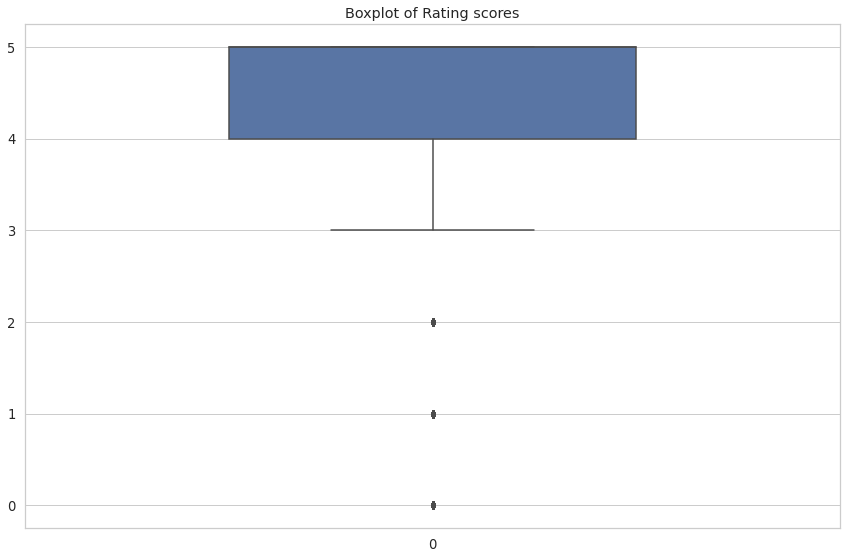

In [15]:
# Generating the figure.
plt.figure(figsize=(12, 8)) # Setting the figure size.
sns.set(style="whitegrid", font_scale=1.2) # Addind a white space on the back and adjustive font scale.
# Creates the boxplot
ax = sns.boxplot(data=ratings_column_pd['Rating'], width=0.5) # Boxplot, setting the width of the box to .5.
ax.set_title('Boxplot of Rating scores') # Add title to the figure.
plt.tight_layout() # Adjusts the layout
plt.show() # Shows the plot

The boxplot shows shows that most of values are located in the maximum values, but also points the score 0, 1 and 2 as outliers, this could be due to the fact that those values represents a small percentage of the total (approximately 7-8%). So based on IQR calculations are considering them as outliers.

- The values 1 and 2 will not be outliers, despite being a small amount they represent negative score reviews of the recipe;
- The value of 0 will be analysed in a later stage along with the writen review.

Despite considering of 1 and 2 score rating outliers, they will remain in the dataset. This is because they are still a valid data point and very important to achieve the goal. Although, the score zeros will be further analysed.

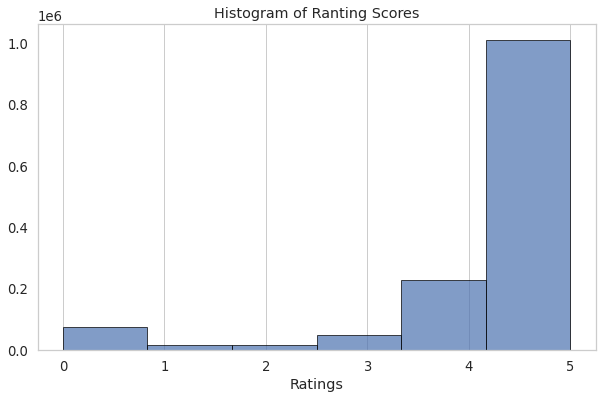

In [16]:
# Creating the figure for the histogram.
plt.figure(figsize=(10, 6))
# Plots the histogram, bins set at 6 because of the range of the value.
plt.hist(ratings_column_pd['Rating'], bins=6, edgecolor='black', alpha=0.7)
plt.title("Histogram of Ranting Scores") # Sets title.
plt.xlabel("Ratings") # Sets x label.
plt.xticks(range(6)) # Add ticks with range between 0 and 6.
plt.grid(axis='y') 
plt.show() # Display the histogram.

An extra visualization to look at the distribution of the data, the histogram shows that the ratings scores data is highly skewed to the left and most of its values are located at the maximum score.

The scores zero raised doubts about its reliability, potentially someone forgot to leave a score or if it is actually the worst score. Also, there are no notes about the score zero, so a manual check will be applied to check if there is a balance between the review and the score zero. The procedure will be done by looking at random samples (attempted multiple times with differend seed values), checking if the reviews truly represents a sentiment of a lowest score possible.

In [17]:
zero_reviews = df_reviews.filter(col("Rating") == 0)
sample_reviews = zero_reviews.sample(withReplacement=False, fraction=0.25, seed=70)
sample_reviews.select("Review").show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Review                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

- According to last code (with many attempts using different seed numbers), the written reviews does not match the score zero given. Positives reviews such as, great recipe, its delicious . Therefore, the chosen option is to drop the 0 scores (anomalies), so it does not affects the analysis by introducing noise to it, increasing the consistency in the data.
- And since they are anomalies in the data, the rows with score of 0 will be dropped.
<br><br><br>The next two codes will be used to drop (by using the method filter) and after printing the counts before and after the operation to check if it was correct. 

In [18]:
# Method filter to exclude the rows with Rating equal to zero.
df_reviews_no_zero = df_reviews.filter(df_reviews.Rating != 0)

In [19]:
# Counting observations before and after the exclusion and printing them for verification. 
original_count = df_reviews.count()
filtered_count = df_reviews_no_zero.count()
print(f"Original obs count: {original_count}")
print(f"After filter obs count: {filtered_count}")

Original obs count: 1401982
After filter obs count: 1325734


- After the drop, the observations reduced by 76248, which is the number of zero scores given (also provided at the frequency line of code). Therefore, the drop operation was sucessful.

## 3. Text pre-processing

Next stage will be the text processing of the Review column, however only a few steps of the pre processing will be called before splitting the dataset to avoid data leakage. And the steps before dividing into traininig, validation and test are:

- Label definition; 
- Lowering case; 
- Removing punctuations and \r\n;

First a column (label) will be created with positive, negative and neutral labels according to the rating score given by the reviewer. This feature will be the sentiment label.

In [20]:
# Creates a new column 'label' based on rating values
df_reviews_no_zero = df_reviews_no_zero.withColumn("label", 
                   when(col("rating").isin([1, 2]), "negative")
                   .when(col("rating") == 3, "neutral")
                   .otherwise("positive")
                  )

# You can verify by showing a few records
df_reviews_no_zero.select("rating", "label").show()


+------+--------+
|rating|   label|
+------+--------+
|     5|positive|
|     4|positive|
|     2|negative|
|     5|positive|
|     5|positive|
|     4|positive|
|     5|positive|
|     5|positive|
|     5|positive|
|     4|positive|
|     5|positive|
|     5|positive|
|     1|negative|
|     5|positive|
|     4|positive|
|     1|negative|
|     5|positive|
|     5|positive|
|     3| neutral|
|     4|positive|
+------+--------+
only showing top 20 rows



According to the last cell, the label features was successfully created. Next, the dataset will be transformed into lower case letters.

In [21]:
# Creating a column named Review_lower to the dataframe in a lowercase version.
process_reviews = df_reviews_no_zero.withColumn("Review_lower", lower(col("Review")))

In [22]:
# Looks for any observation that the transformation did not work.
no_match = process_reviews.filter(lower(col("Review")) !=col("Review_lower")).count()

if no_match == 0:
    print("Transformation successful.")
else:
    print("There is/are rows that the transformation did not work.")

Transformation successful.


- After the transformation, a few statistical features will be generated before further processing for comparison purpose. 

In [23]:
# It sums the number of words in the review column.
w_count = process_reviews.withColumn("word_count", size(split(process_reviews["Review_lower"], " ")))
# Display statistical features of the review number of words.
w_count.select("word_count").describe().show()

+-------+-----------------+
|summary|       word_count|
+-------+-----------------+
|  count|          1325734|
|   mean|53.35392393949314|
| stddev|37.57547429823871|
|    min|                1|
|    max|             1184|
+-------+-----------------+



According to the descriptive statistics of the review word count (1,325,734 in total):
- It ranges from 1 word to 1184 words;
- The mean is 53.35, thus the average of words is 53 words per review.
- Most of the reviews are likely to be clustered in the lower values. 

In [24]:
# Displaying the characters length of the review_lowercase column
process_reviews = process_reviews.withColumn("rev_char_length", length(process_reviews["Review_lower"]))
# Displaying statistical feature of the reviews character length. 
process_reviews.select("rev_char_length").describe().show()

+-------+------------------+
|summary|   rev_char_length|
+-------+------------------+
|  count|           1325734|
|   mean| 276.9054689703968|
| stddev|194.79580324070147|
|    min|                 0|
|    max|              8587|
+-------+------------------+



At this stage, the review features has:
- An average of 276 characters per review;
- Reviews range from 0 (empty) to 8587 (long reviews);

Based on the values, the mean is much closer to the minimum than to the maximum value, therefore indicating that the distribution of the character length is right skewed. However, the histogram will be generate to be certain.

In [25]:
# Transforming to pandas dataframe for visualization purpose.
review_char_lengh_pd = process_reviews.select("rev_char_length").toPandas()

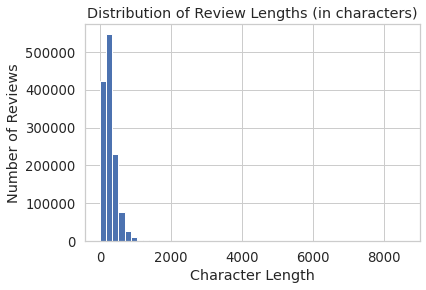

In [26]:
# Creating histogram for characters length
char_lengths = review_char_lengh_pd["rev_char_length"] # Data
char_lengths.hist(bins=50) # Generate histogram.
plt.xlabel("Character Length") # Adds label.
plt.ylabel("Number of Reviews") # Adds label.
plt.title("Distribution of Review Lengths (in characters)") # Adds title.
plt.show() # Shows the histogram.

- The histogram confirms what the descriptive statistic showed, that the distribution for the number of characters is right-skewed. 

# CHECK IF YOU CAN OPTIMIZE THIS CODE BECAUSE YOU HAVE THE LABEL ALREADY!!!!

replace if works

In [29]:
# Group by the label column to get counts
class_counts = process_reviews.groupBy("label").count().rdd.collectAsMap()

# Calculate the total number of reviews
total_reviews = sum(class_counts.values())

# Calculate the ratios
Ratios = {k: v / total_reviews for k, v in class_counts.items()}

# Print the percentages
for label, ratio in Ratios.items():
    print(f"Rating Class {label.capitalize()}: {ratio*100:.2f}%")


Rating Class Positive: 93.63%
Rating Class Neutral: 3.79%
Rating Class Negative: 2.58%


Through the last line of code, the reviews have:

- By far, the highest number of score given is between the value of 4 and 5;
- Lower scores (1 , 2) represents less than 3% of the total of ratings given and less than 4% for neutral scores (3); <b> (Important rationale to balance the data in a later stage)</b>
- The imbalance between the positive classes are enourmous considering the others, and this potenlially could add bias into the sentiment analysis. To mitigate this issue there are some options available which will be attempt in a later stage. 

Next pre processing stage is to remove punctuations and characters such as \r\n.

In [30]:
# Removing punctions of the Review_lowercase column.
process_reviews = process_reviews.withColumn("Review_no_punct", regexp_replace(col("Review_lower"), "[^a-zA-Z\s]", ""))

In [31]:
# Displays the rows of column before and after the removal of punctuations. 
process_reviews.select("Review_lower", "Review_no_punct").show(n=20, truncate=False)   

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Review_lower                                                                                                                                                                                                                                                                                                               

- The previous line of code shows that the removal of puctuations was successful. However, it shows special characters like \r\n, which will be removed in the following step.

In [32]:
# Removing \r\n.
process_reviews = process_reviews.withColumn("Review_no_punct2", regexp_replace(col("Review_no_punct"), "[\r\n]", ""))

In [33]:
# Checking the results of the last operation.
process_reviews.select("Review_no_punct", "Review_no_punct2").show(n=20, truncate=False)  

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Review_no_punct                                                                                                                                                                                                                                                                                                                            |Review_no_punct2     

- The last code showed that \r\n characters also were removed.  

### After a few steps of processing, the dataset will be split into three different sets, the training, validation and test. 

- The split of the sets will be performed also by using the command sampleBy, in which will divide the reviews dataframe into three different sets, however it will keep the original ratio as close as possible.
- The rationale behing the split to occur at this stage is to avoid as much as possible the data leaked, in order words, do not give access to information which the model is not supposed to look at it.
- The division will be performed using fractions in order to keep the same ratio and distribution as the original dataset. 

<br>
The sets will be separeted in the following ratio training (60%), validation (20%) and test (20%). The process will be conducted using seed 42, for the same representation when running the code.  

In [34]:
# Defining fractions to split the dataset.
train_fractions = {label: 0.6 for label in process_reviews.select("label").distinct().rdd.flatMap(lambda x: x).collect()}

# Creating a train set.
df_train = process_reviews.sampleBy("label", fractions=train_fractions, seed=42)

In [35]:
# Creates the 40% left set to be splitted between validation and test.
remaining_df = process_reviews.subtract(df_train)

In [36]:
# Defining fractions to split the dataset.
valid_fractions = {label: 0.5 for label in process_reviews.select("label").distinct().rdd.flatMap(lambda x: x).collect()}

# Creates the validation set from the 40%, using its franction of 
df_valid = remaining_df.sampleBy("label", fractions=valid_fractions, seed=42)

In [37]:
# Creating test df. 
df_test = remaining_df.subtract(df_valid)

In [38]:
# Displaying the class distributions after the split using the stratified method.
df_train.groupBy("label").count().show()
df_valid.groupBy("label").count().show()
df_test.groupBy("label").count().show()

+--------+------+
|   label| count|
+--------+------+
|positive|745635|
| neutral| 30424|
|negative| 20526|
+--------+------+



2023-10-04 23:11:44,301 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-10-04 23:11:44,315 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-10-04 23:11:44,335 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-10-04 23:11:44,352 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+--------+------+
|   label| count|
+--------+------+
|positive|248220|
| neutral|  9876|
|negative|  6832|
+--------+------+



+--------+------+
|   label| count|
+--------+------+
|positive|247486|
| neutral|  9947|
|negative|  6788|
+--------+------+



In [ ]:
# Creating a function to display the descripte statistics.
def describe_word_count(dataset, dataset_name):
    # Calculate word count and add as a new column
    dataset_with_count = dataset.withColumn("word_count", size(split(dataset["Review_lower"], " ")))
    
    # Describes the word count and show the statistics.
    print(f"Word count statistics for {dataset_name}:")
    dataset_with_count.select("word_count").describe().show()

    return dataset_with_count

# Applying the function to X_train, X_val, and X_test.
df_train_R = describe_word_count(df_train, "Training Set")
df_valid_R = describe_word_count(df_valid, "Validation Set")
df_test_R = describe_word_count(df_test, "Test Set")


Word count statistics for Training Set:


+-------+-----------------+
|summary|       word_count|
+-------+-----------------+
|  count|           796585|
|   mean| 53.3311297601637|
| stddev|37.56732519939138|
|    min|                1|
|    max|              944|
+-------+-----------------+

Word count statistics for Validation Set:


- The results regarding the proportion being (0.6, 0.2, 0.2) are successful, for example the training set has 796,585 reviews, which represents 60% of the total (1,325,734).
- The average number of words per review are equal among the sets. Despite the same averages the sets vary in the maximum value of words. 

# OPTIMIZE IT, YOU HAVE THE LABEL COLUMN ALREADY!!!!

- Try to run the code below if it works, replace it and erase this line.

In [ ]:
# Calculating the distribution of scores and the three different classes fo the train set.
# Group by the label column to get counts.
class_counts_train = df_train.groupBy("label").count().rdd.collectAsMap()

# Calculate the total number of reviews.
total_reviews_train = sum(class_counts_train.values())

# Calculates the ratios.
Ratios = {k: v / total_reviews_train for k, v in class_counts.items()}

# Prints the percentages.
for label, ratio in Ratios.items():
    print(f"Rating Class {label.capitalize()}: {ratio*100:.2f}%")


In [ ]:
# Calculating the distribution of scores and the three different classes fo the train set.
# Placing the 1,2 to the negatives, 3 neutral and 4,5 positives.
class_counts = (
    df_train.withColumn(
    "Rating_class",
    when((df_train['Rating'] >= 1) & (df_train['Rating'] <= 2), "Negatives (1-2)")
    .when(df_train['Rating'] == 3, "Neutral (3)")
    .otherwise("Positives (4-5)"))
# Grouping the ratings into its class and using rdd to transform them into a dictionary which is easier to access in a query.
    .groupBy("Rating_class")
    .count()
    .rdd.collectAsMap())

# Calculates to total number of reviews.
total_reviews = sum(class_counts.values())
# Calculates the ratio.
Ratios = {k: v / total_reviews for k, v in class_counts.items()}
# Prints the percentages.
for Rating_class, ratio in Ratios.items():
    print(f"Rating Class {Rating_class}: {ratio*100:2f}%")

- Based on the last code, it is observable that the ratio between before and after the split are similiar for all three classes. 

Next step will separete the sentence into words (tokens)
- The tokenizer provided by Keras has an additional feature which is possible to set the maximum number of words, however in the Spark enviroment this feature is not available. Therefore, the number of words that are going to be used in the padding stage which will be performed in a later stage.

### Tokenizing all sets.

In [ ]:
# Initialize a tokenizer
tokenizer = Tokenizer(inputCol="Review_no_punct2", outputCol="tokens")

# Tokenize X_train
df_train_token = tokenizer.transform(df_train)

# Tokenize X_val
df_val_token = tokenizer.transform(df_valid)

# Tokenize X_test
df_test_token = tokenizer.transform(df_test)


- There are pre processing steps that could have been called before tokenization, such as removal of stop words, however in the Spark environment the command only removes when its separeted. Therefore pre processing steps will be performed also after the tokenization. 

In [ ]:
# It "explodes" the tokens column to have one token per row.
df_train_token_exploded = df_train_token.select(explode("tokens").alias("words"))

# Groups individual by tokens and count their occurrences.
word_counts = df_train_token_exploded.groupBy("words").agg(count("words").alias("count"))

# Orders by count in descending order to see most frequent words at the top.
word_counts_ordered_train = word_counts.orderBy(desc("count"))

# Show the results.
word_counts_ordered_train.show()

- As shown in the previous cell that there are spaces being counted which does not have any meaning to the model. The removal of this character will be filtering out short tokens (less than 2), the reason for the number is that word like "no".

Thus, the next two lines of code will filter out short tokens with lenght that are less than 2 characters, including the spaces. 

### Filter short tokens (less than 2)

In [ ]:
# UDF to filter out short tokens in all three sets.
filter_short_udf = udf(lambda tokens: [token for token in tokens if len(token) > 1], ArrayType(StringType()))

df_train = df_train_token.withColumn("filt_tokens", filter_short_udf(df_train_token["tokens"]))
df_val = df_val_token.withColumn("filt_tokens", filter_short_udf(df_val_token["tokens"]))
df_test = df_test_token.withColumn("filt_tokens", filter_short_udf(df_test_token["tokens"]))

In [ ]:
# It "explodes" the tokens column to have one token per row.
df_train_exploded = df_train.select(explode("filt_tokens").alias("words"))

# Groups individual by tokens and count their occurrences.
word_counts = df_train_exploded.groupBy("words").agg(count("words").alias("count"))

# Orders by count in descending order to see most frequent words at the top.
word_counts_ordered = word_counts.orderBy(desc("count"))

# Show the results.
word_counts_ordered.show()

- Based on the results, spaces, letters such as i, a, are not present anymore. Thus, the operation of filtering the short tokens was successful.

Next transformation to be called is to remove the stop words, a step that can be performed in early stages, although on Spark, setences has to be separeted by words. Thus this is why this step is being used now. 

### Removing Stop Words

In [ ]:
# Defines the stopword remover.
remover = StopWordsRemover(inputCol="filt_tokens", outputCol="tokens_no_stopwords")

# Removes stopwords from the training dataset.
df_train = remover.transform(df_train)

# Removes stopwords from the validation dataset.
df_val = remover.transform(df_val)

# Removes stopwords from the test dataset.
df_test = remover.transform(df_test)


- After some stages of pre processing (mainly transformations) the reviews, it could potentially create empty cells, for example a review with just punctuations or with just stopwords. Therefore, the following code will search for empty reviews in all three datasets. 

In [ ]:
def count_empty_reviews(dataset, dataset_name):
    # Filter the empty token reviews
    empty_token_reviews = dataset.filter(size(dataset["tokens_no_stopwords"]) == 0)
    
    # Count the number of empty reviews
    empty_count = empty_token_reviews.count()
    
    # Print and return the result
    print(f"Number of empty reviews in {dataset_name}: {empty_count}")
    return empty_count

# Count empty reviews in X_train, X_val, and X_test
empty_train_count = count_empty_reviews(df_train, "Training Set")
empty_val_count = count_empty_reviews(df_val, "Validation Set")
empty_test_count = count_empty_reviews(df_test, "Test Set")


- The results of the last code shows that all the three sets now have a few empty cells, that might have been transformed to empty due to transformations. Therefore, the chosen option will be to drop the empty ones because it could potentially impact model efficiency.

In [ ]:
def filter_empty_reviews(dataset):
    return dataset.filter(size(dataset["tokens_no_stopwords"]) > 0)

# Filter out empty reviews in X_train, X_val, and X_test
df_train = filter_empty_reviews(df_train)
df_val = filter_empty_reviews(df_val)
df_test = filter_empty_reviews(df_test)

- After removing the stop words and filtering out short tokens, the number of observations in the review column with zero tokes increased from 4 to 327, which the amount for each score can be looked at the previous code.

The chosen solution for the empty rows after the transformation is to drop them, performed in the next line of code. 

The stage of text processing almost at the final stage, the descriptive statistical of the reviews suffered a big change. 
- Started with 1,401,982 rows and at this stage have 1,325,407, a reduction of 76,575.
- The mean of 53 reduced to 26, meaning that the average length of words in each review reduced more than 50%, a big decrease. 
- Standard Deviation, also reduced around 50%.
- The max length also slumped, from more than 1100 words it is now 639.  

- For computational resources (time consuming), but also because the maximum length of words is going to be taken from the train set, thus the only set (X_train) that will be performed the word count and frequency, along with visualization. The next following line of codes will help identify the maximum length words to be used during the padding stage.

The tokenizer provided by Keras has an additional feature which is possible to set the maximum number of words, however in the Spark enviroment this feature is not available. Therefore, the number of words that are going to be used in the padding stage will be performed next.

In [ ]:
# It "explodes" the tokens column to have one token per row.
df_train_exploded = df_train.select(explode("tokens_no_stopwords").alias("words"))

# Groups individual by tokens and count their occurrences.
word_counts = df_train_exploded.groupBy("words").agg(count("words").alias("count"))

# Orders by count in descending order to see most frequent words at the top.
word_counts_ordered = word_counts.orderBy(desc("count"))

# Show the results.
word_counts_ordered.show()

In [ ]:
# Convert the word counts to pandas dataframe for visualization
word_counts_ordered = word_counts_ordered.toPandas()

# Plot the word frequencies
plt.figure(figsize=(12, 6))
plt.plot(word_counts_ordered['count'].values)  # this plots word counts in descending order
plt.xlabel('Words Rank')
# Set x-axis limit
plt.xlim(0, 1500)
plt.ylabel('Frequency')
plt.title('Word Frequency Distribution')
plt.show()

In [ ]:
aaaa

In [ ]:
word_counts = (df_train.select(explode(col("tokens_no_stopwords")).alias("word"))
               .groupBy("word")
               .count()
               .orderBy(col("count").desc()))

# Compute total word occurrences
total_word_occurrences = word_counts.agg({"count": "sum"}).collect()[0][0]

# Compute occurrences of top N words
N = 1000
top_N_word_occurrences = word_counts.limit(N).agg({"count": "sum"}).collect()[0][0]

# Compute the coverage
coverage = (top_N_word_occurrences / total_word_occurrences) * 100

print("Total word occurrences:", total_word_occurrences)
print(f"Occurrences of top {N} words:", top_N_word_occurrences)
print(f"Coverage of top {N} words: {coverage:.2f}%")


In [ ]:
# Converts word_counts_ordered to a Pandas dataframe, only for visualization purpose. 
word_counts_pd = word_counts_ordered.toPandas()

# 2. Compute the cumulative sum of the word frequencies
word_counts_pd['cumulative_freq'] = word_counts_pd['count'].cumsum()
word_counts_pd['cumulative_freq'] /= word_counts_pd['count'].sum()  # normalize to get the CDF

# 3. Plot the CDF
plt.figure(figsize=(10, 6))
plt.plot(word_counts_pd['cumulative_freq'], marker='.', linestyle='none')
plt.xlabel('Word Rank')
plt.ylabel('CDF')
plt.title('CDF of Word Frequencies')
plt.grid(True)
plt.show()


- Feature Engineering

In [ ]:
# Extract as DataFrames, not Columns
X_train = df_train.select(["tokens_no_stopwords"])
y_train = df_train.select(["label"])

X_val = df_val.select(["tokens_no_stopwords"])
y_val = df_val.select(["label"])

X_test = df_test.select(["tokens_no_stopwords"])
y_test = df_test.select(["label"])

In [ ]:
import spacy
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

# Load spaCy model
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "textcat"])

@udf(ArrayType(StringType()))
def lemmatize_udf(tokens):
    # Convert list of tokens to single string
    doc = nlp(" ".join(tokens))
    
    # Return list of lemmatized tokens
    return [token.lemma_ for token in doc]

# Apply the UDF
# Apply the UDF to all three datasets
X_train = X_train.withColumn("lemmatized_tokens", lemmatize_udf(X_train["tokens_no_stopwords"]))
X_val = X_val.withColumn("lemmatized_tokens", lemmatize_udf(X_val["tokens_no_stopwords"]))
X_test = X_test.withColumn("lemmatized_tokens", lemmatize_udf(X_test["tokens_no_stopwords"]))

In [ ]:
X_train.select("tokens_no_stopwords", "lemmatized_tokens").show(truncate=False)

- The previous code shows that the lemmatization was a success, words such as working became work, called is also call.

In [ ]:
from pyspark.ml.feature import Word2Vec

# Step 1: Define the Word2Vec model
# The input column should be the column containing the lemmatized tokens
# The output column will be where the vectors are stored
# You can adjust the vectorSize and minCount parameters based on your data and requirements

word2Vec = Word2Vec(vectorSize=100, minCount=5, inputCol="lemmatized_tokens", outputCol="Review")

# Step 2: Train the Word2Vec model on the training set
model = word2Vec.fit(X_train)


In [ ]:
# Step 3: Use the trained model to transform all datasets
X_train_trans = model.transform(X_train)
X_val_trans = model.transform(X_val)
X_test_trans = model.transform(X_test)

In [ ]:
from pyspark.sql.functions import size, collect_list, sort_array
from pyspark.sql.window import Window

# Calculate the length of each sequence
X_train_trans = X_train_trans.withColumn("sequence_length", size("word2vec_output_length"))

# Using describe() to get mean and standard deviation
X_train_trans.describe("sequence_length").show()

# Computing the median
# Sorting the DataFrame by sequence length
sorted_df = X_train_trans.sort("sequence_length")

# Using a window function to get the total count
win = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)
sorted_with_total = sorted_df.withColumn("total_count", count("sequence_length").over(win))

# Filtering out to get the middle value(s)
median_df = sorted_with_total.filter(
    (col("total_count") % 2 == 1 & (col("sequence_length") == (col("total_count") + 1) / 2)) | 
    (col("total_count") % 2 == 0 & 
     ((col("sequence_length") == col("total_count") / 2) | 
      (col("sequence_length") == (col("total_count") + 1) / 2)))
)

median = median_df.collect()[0]["sequence_length"]
print(f"Median Sequence Length: {median}")

# Computing the maximum sequence length
max_length = transformed_train_df.agg({"sequence_length": "max"}).collect()[0][0]
print(f"Maximum Sequence Length: {max_length}")


In [ ]:
# Assuming the 'word2vec_sequence' column holds your Word2Vec sequences
sequence_lengths = X_train_trans.withColumn("sequence_length", size(X_train_trans["Review"]))

# Descriptive statistics
sequence_lengths.describe(["sequence_length"]).show()

# Calculate percentiles
percentiles = sequence_lengths.approxQuantile("sequence_length", [0.9, 0.95, 0.99], 0.01)
print(f"90th percentile: {percentiles[0]}")
print(f"95th percentile: {percentiles[1]}")
print(f"99th percentile: {percentiles[2]}")


In the previous cells it was noticed that the ratio between the "sentiments" are quite imbalanced (the positive one having more than 93%). Thus, due to this a stratified spliting will be applied, a same distribution as the original dataset will be applied to the spliting datasets, training, validation and test.  

In [ ]:
# Separate out different classes from the training dataset
positives = train_combined_for_padding.filter(col("label") == 'positive')
negatives = train_combined_for_padding.filter(col("label") == 'negative')
neutrals = train_combined_for_padding.filter(col("label") == 'neutral')

# Define oversampling factors
negative_oversample_factor = 2.0  # Double the negative samples
neutral_oversample_factor = 1.5   # 1.5 times the neutral samples

oversampled_negatives = negatives.sample(withReplacement=True, fraction=negative_oversample_factor)
oversampled_neutrals = neutrals.sample(withReplacement=True, fraction=neutral_oversample_factor)

# Undersample the majority class
undersample_factor = 0.25  # Reducing by 25%
undersampled_positives = positives.sample(withReplacement=False, fraction=undersample_factor)

# Combine the samples back
bal_X_train = undersampled_positives.unionAll(oversampled_negatives).unionAll(oversampled_neutrals)

# Calculate class weights for the balanced dataset
total_count = bal_X_train.count()
positive_weight = total_count / undersampled_positives.count()
negative_weight = total_count / (negatives.count() * negative_oversample_factor) # can be tweaked (1.5, 2, 2.5)
neutral_weight = total_count / (neutrals.count() * neutral_oversample_factor) # can be tweaked (1.5, 2, 2.5)

# Normalize weights
normalizing_factor = positive_weight + negative_weight + neutral_weight
positive_weight /= normalizing_factor
negative_weight /= normalizing_factor
neutral_weight /= normalizing_factor

class_weights = {
    'positive': positive_weight,
    'negative': negative_weight,
    'neutral': neutral_weight}

In [ ]:
# Count instances for each class
positives = bal_X_train .filter(col("label") == 'positive').count()
negatives = bal_X_train .filter(col("label") == 'negative').count()
neutrals = bal_X_train .filter(col("label") == 'neutral').count()

total_count = positives + negatives + neutrals

# Calculate proportions for each class
positive_ratio = (positives / total_count) * 100
negative_ratio = (negatives / total_count) * 100
neutral_ratio = (neutrals / total_count) * 100

print(f"Rating Class Positives (4-5): {positive_ratio:.2f}%")
print(f"Rating Class Negatives (1-2): {negative_ratio:.2f}%")
print(f"Rating Class Neutral (3): {neutral_ratio:.2f}%")


# ADD PADDING

In [ ]:
from keras.preprocessing.sequence import pad_sequences

# `sequences` is a list of lists, where each inner list is a sequence of word indices.
padded_sequences = pad_sequences(sequences, padding='post')


In [ ]:
# Assuming X_train and y_train are Spark DataFrames
train_combined_for_padding = df_train.join(y_train)
# Display the columns of the joined set.
train_combined_for_padding.columns

As observed in previous cells, the gap ratio between the classes are large. Therefore, a few techniques will be combined to reduce the imbalaced between positive (93.63%), negative (2.58%) and neutral (3.79).<br><br> 
The first technique is the oversampling, increasing the size of the negative and neutral sample. It is worthy mentioning that this may cause overfiting, because it will increase by copying the data that already has.<b> WRITE THE AMOUNT OF THE INCREASE (DOUBLE TRIPLE...), NEED TO EXPERIMENT BASED ON RESULTS OF THE MODEL.</b><br><br>
The second is to undersample the positive side (93.63%) and it will be reduced by <b> SAME APPLY HERE AS THE PREVIOUS ONE.</b> One of the downfalls is the lost of information by reducing the sample.<br><br>
The last one is to apply class weights, <b>CHECK IF ITS GONNA BE SURE</b>, because even after the over and undersampling the imbalance is still present but not as large as the original.

In [ ]:
# Separate out different classes from the training dataset
positives = train_df.filter(col("label") == 'positive')
negatives = train_df.filter(col("label") == 'negative')
neutrals = train_df.filter(col("label") == 'neutral')

# Define oversampling factors
negative_oversample_factor = 2.0  # Double the negative samples
neutral_oversample_factor = 1.5   # 1.5 times the neutral samples

oversampled_negatives = negatives.sample(withReplacement=True, fraction=negative_oversample_factor)
oversampled_neutrals = neutrals.sample(withReplacement=True, fraction=neutral_oversample_factor)

# Undersample the majority class
undersample_factor = 0.25  # Reducing by 25%
undersampled_positives = positives.sample(withReplacement=False, fraction=undersample_factor)

# Combine the samples back
balanced_train_df = undersampled_positives.unionAll(oversampled_negatives).unionAll(oversampled_neutrals)

# Calculate class weights for the balanced dataset
total_count = balanced_train_df.count()
positive_weight = total_count / undersampled_positives.count()
negative_weight = total_count / (negatives.count() * negative_oversample_factor) # can be tweaked (1.5, 2, 2.5)
neutral_weight = total_count / (neutrals.count() * neutral_oversample_factor) # can be tweaked (1.5, 2, 2.5)

# Normalize weights
normalizing_factor = positive_weight + negative_weight + neutral_weight
positive_weight /= normalizing_factor
negative_weight /= normalizing_factor
neutral_weight /= normalizing_factor

class_weights = {
    'positive': positive_weight,
    'negative': negative_weight,
    'neutral': neutral_weight}

In [ ]:
# Count instances for each class
positives = balanced_train_df.filter(col("label") == 'positive').count()
negatives = balanced_train_df.filter(col("label") == 'negative').count()
neutrals = balanced_train_df.filter(col("label") == 'neutral').count()

total_count = positives + negatives + neutrals

# Calculate proportions for each class
positive_ratio = (positives / total_count) * 100
negative_ratio = (negatives / total_count) * 100
neutral_ratio = (neutrals / total_count) * 100

print(f"Rating Class Positives (4-5): {positive_ratio:.2f}%")
print(f"Rating Class Negatives (1-2): {negative_ratio:.2f}%")
print(f"Rating Class Neutral (3): {neutral_ratio:.2f}%")
